In [1]:
import csv
import pickle
import json
import spacy
import re
import string
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

In [2]:
# Note that since tweets deviate from standard English (and other languages) and embody a unique "slang", this notebook "cleans" tweets manually and does not use any existing
# machinery from "really good" packages such as Spacy and NLTK; hence stop words from Gensim and listed here and removed as appropriate (This list is presented here since it 
# facilitates inclusion of additional stop words and removal if twitter meaning is being lost...)
stop_words = ['her', 'during', 'among', 'thereafter', 'only', 'hers', 'in', 'none', 'with', 'un', 'put', 'hence', 'each', 'would', 'have', 'to', 'itself', 'that', 'seeming', 
              'hereupon', 'someone', 'eight', 'she', 'forty', 'much', 'throughout', 'less', 'was', 'interest', 'elsewhere', 'already', 'whatever', 'or', 'seem', 'fire', 
              'however', 'keep', 'detail', 'both', 'yourselves', 'indeed', 'enough', 'too', 'us', 'wherein', 'himself', 'behind', 'everything', 'part', 'made', 'thereupon', 
              'for', 'nor', 'before', 'front', 'sincere', 'really', 'than', 'alone', 'doing', 'amongst', 'across', 'him', 'another', 'some', 'whoever', 'four', 'other', 
              'latterly', 'off', 'sometime', 'above', 'often', 'herein', 'am', 'whereby', 'although', 'who', 'should', 'amount', 'anyway', 'else', 'upon', 'this', 'when', 
              'we', 'few', 'anywhere', 'will', 'though', 'being', 'fill', 'used', 'full', 'thru', 'call', 'whereafter', 'various', 'has', 'same', 'former', 'whereas', 'what', 
              'had', 'mostly', 'onto', 'go', 'could', 'yourself', 'meanwhile', 'beyond', 'beside', 'ours', 'side', 'our', 'five', 'nobody', 'herself', 'is', 'ever', 'they', 'here', 
              'eleven', 'fifty', 'therefore', 'nothing', 'not', 'mill', 'without', 'whence', 'get', 'whither', 'then', 'no', 'own', 'many', 'anything', 'etc', 'make', 'from', 
              'against', 'ltd', 'next', 'afterwards', 'unless', 'while', 'thin', 'beforehand', 'by', 'amoungst', 'you', 'third', 'as', 'those', 'done', 'becoming', 'say', 'either', 
              'doesn', 'twenty', 'his', 'yet', 'latter', 'somehow', 'are', 'these', 'mine', 'under', 'take', 'whose', 'others', 'over', 'perhaps', 'thence', 'does', 'where', 
              'two', 'always', 'your', 'wherever', 'became', 'which', 'about', 'but', 'towards', 'still', 'rather', 'quite', 'whether', 'somewhere', 'might', 'do', 'bottom', 
              'until', 'km', 'yours', 'serious', 'find', 'please', 'hasnt', 'otherwise', 'six', 'toward', 'sometimes', 'of', 'fifteen', 'eg', 'just', 'a', 'me', 'describe', 
              'why', 'an', 'and', 'may', 'within', 'kg', 'con', 're', 'nevertheless', 'through', 'very', 'anyhow', 'down', 'nowhere', 'now', 'it', 'cant', 'de', 'move', 'hereby', 
              'how', 'found', 'whom', 'were', 'together', 'again', 'moreover', 'first', 'never', 'below', 'between', 'computer', 'ten', 'into', 'see', 'everywhere', 'there', 
              'neither', 'every', 'couldnt', 'up', 'several', 'the', 'i', 'becomes', 'don', 'ie', 'been', 'whereupon', 'seemed', 'most', 'noone', 'whole', 'must', 'cannot', 'per', 
              'my', 'thereby', 'so', 'he', 'name', 'co', 'its', 'everyone', 'if', 'become', 'thick', 'thus', 'regarding', 'didn', 'give', 'all', 'show', 'any', 'using', 'on', 
              'further', 'around', 'back', 'least', 'since', 'anyone', 'once', 'can', 'bill', 'hereafter', 'be', 'seems', 'their', 'myself', 'nine', 'also', 'system', 'at', 'more', 
              'out', 'twelve', 'therein', 'almost', 'except', 'last', 'did', 'something', 'besides', 'via', 'whenever', 'formerly', 'cry', 'one', 'hundred', 'sixty', 'after', 
              'well', 'them', 'namely', 'empty', 'three', 'even', 'along', 'because', 'ourselves', 'such', 'top', 'due', 'inc', 'themselves']

In [3]:
# read in tweet train data from csv file
tw = pd.read_csv('D:\\Data\\Tweet\\training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)
tw.columns = ['sentiment', 'index', 'date/time', 'query', 'user', 'tweet']

In [4]:
# display head entries
tw.head()

,sentiment,index,date/time,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# display tail entries
tw.tail()

,sentiment,index,date/time,query,user,tweet
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
# convert data to numpy arrays
tweets = tw['tweet'].values
labels = tw['sentiment'].values
print("Extracted {} tweets and {} labels...".format(tweets.shape[0], labels.shape[0]))

Extracted 1600000 tweets and 1600000 labels...


In [7]:
# method to strip all entities from tweet - users, handles
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
# clean tweets - remove users, handles, punctuation, numbers, urls
# note tested lemmatization with Spacy but had little effect (so not included here)

punctuations = '''()-[]{};:"\,<>./?@#$%^&_~'''             # masks to remove all punctuation except for ! and * and '
numbers = '''0123456789'''                                 # mask to remove all numbers

tweet_words = []
for idx, tweet in enumerate(tweets):
    # print(tweet)
    tweet = str(tweet)
    tweet = re.sub(r'http\S+', '', tweet.strip())          # remove urls
    tweet = strip_all_entities(tweet).lower()              # remove entities
    for t in tweet:
        if t in punctuations or t in numbers:
            tweet = tweet.replace(t, " ")                  # non-regex removal of selected punctuation and numbers
    tweet = re.sub('\s+',' ', tweet.strip())               # remove extra whitespace from punctuation removal 
    tweet_words.append(tweet.split(' '))
    tweets[idx] = tweet

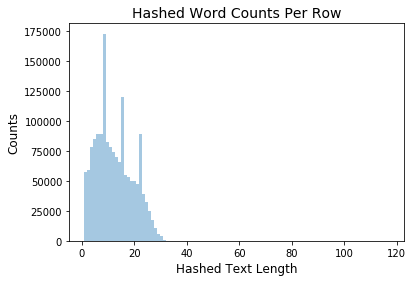

In [9]:
# find distribution of words per tweet to set record length for training vectors
word_counts_per_row = []
max_row_len = 0

for idx, tweet in enumerate(tweets):        
    try:
        words = tweet.split(' ')
        wlen = len(words)
        word_counts_per_row.append(wlen)
    except AttributeError:
         print("AttributeError at idx: ", idx)
    
sns.distplot(word_counts_per_row, kde=False, bins=100)
plt.title('Hashed Word Counts Per Row', fontsize=14)
plt.xlabel('Hashed Text Length', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

In [10]:
# method to form word clouds from text
def word_cloud(tweet_dict):
    # generate the wordcloud using the series created and the mask 
    wc = WordCloud(width=2000, height=1000, max_font_size=200,  background_color="black", max_words=500, contour_width=1, contour_color="steelblue", colormap="nipy_spectral")
    wc.generate_from_frequencies(tweet_dict)

    plt.figure(figsize=(20,10))
    # plt.imshow(wc, interpolation="bilinear")
    plt.imshow(wc, interpolation="hermite")
    plt.axis("off")    
    plt.show()   

In [11]:
# extract positive and negative tweets
positive_tweets = []
neutral_tweets = []
negative_tweets = []
for idx, tweet in enumerate(tweets):
    if labels[idx] == 0:
        negative_tweets.append(tweet)
    elif labels[idx] == 2:
        neutral_tweets.append(tweet)
    elif labels[idx] == 4:
        positive_tweets.append(tweet)
        
print("There are {} positive, {} neutral and {} negative tweets...".format(len(positive_tweets), len(neutral_tweets), len(negative_tweets)))
# print(positive_tweets[0:20])

There are 800000 positive, 0 neutral and 800000 negative tweets...


In [12]:
# method to create word frequency dict from list of tweets
def word_dict(tweets):
    words = {}
    for tweet in tweets:
        text = tweet.split(' ')
        for t in text:
            if t in stop_words:
                continue
            if t in words:
                words[t] += 1
            else:
                words[t] = 1
    return {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

In [13]:
# determine word frequency in positive and negative tweets
positive_word_dict = word_dict(positive_tweets)
negative_word_dict = word_dict(negative_tweets)

Positive Tweets


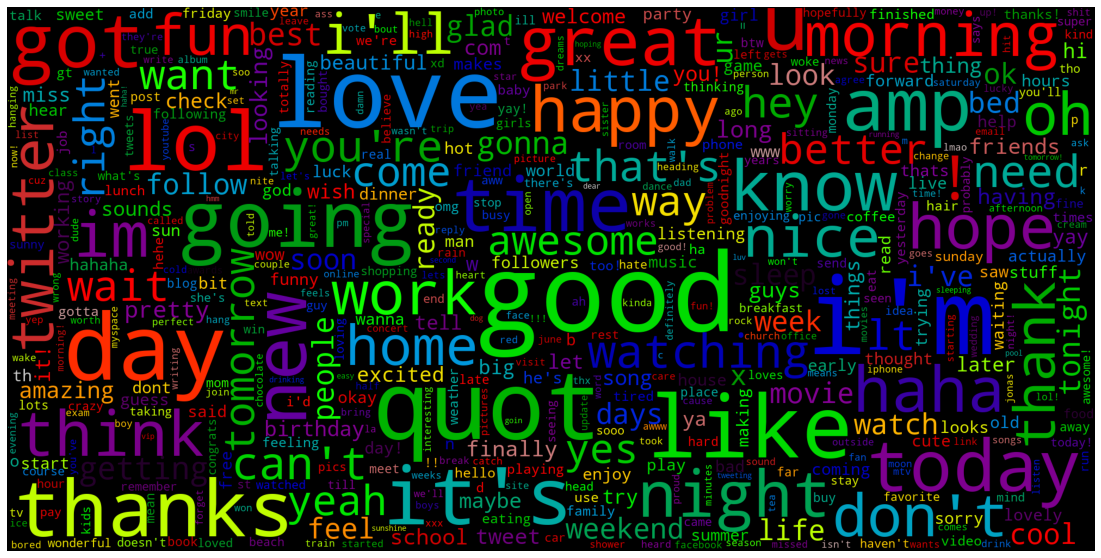

Negative Tweets


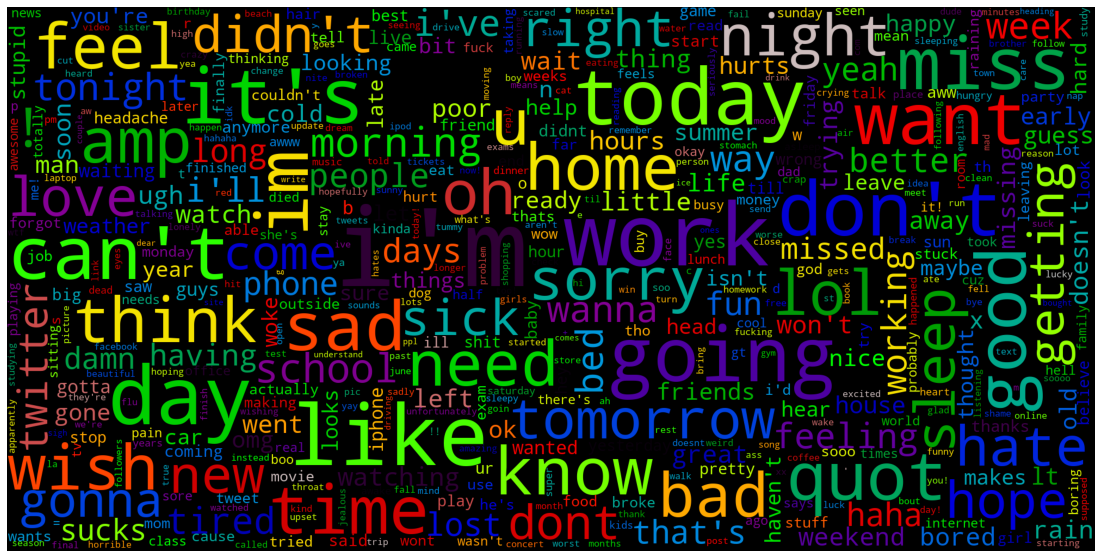

In [14]:
# show word cloud for positive and negative tweets
print("Positive Tweets")
word_cloud(positive_word_dict)
print("Negative Tweets")
word_cloud(negative_word_dict)

In [15]:
# method to show word frequencies in tweet dicts
def show_frequencies(tweet_dict, dict_name):
    labels = list(tweet_dict.keys())
    values = list(tweet_dict.values())
    title = "Word Frequency for {}".format(dict_name)
    
    plt.figure(figsize=(20, 10))
    plt.bar(np.arange(50), values[0: 50], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, edgecolor = "black", capsize=8, linewidth=1)
    plt.xticks(np.arange(50), labels[0: 50], rotation=90, size=14)
    plt.xlabel("Most Frequent Words", size=14)
    plt.ylabel("Frequency", size=14)
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

Positive Tweets


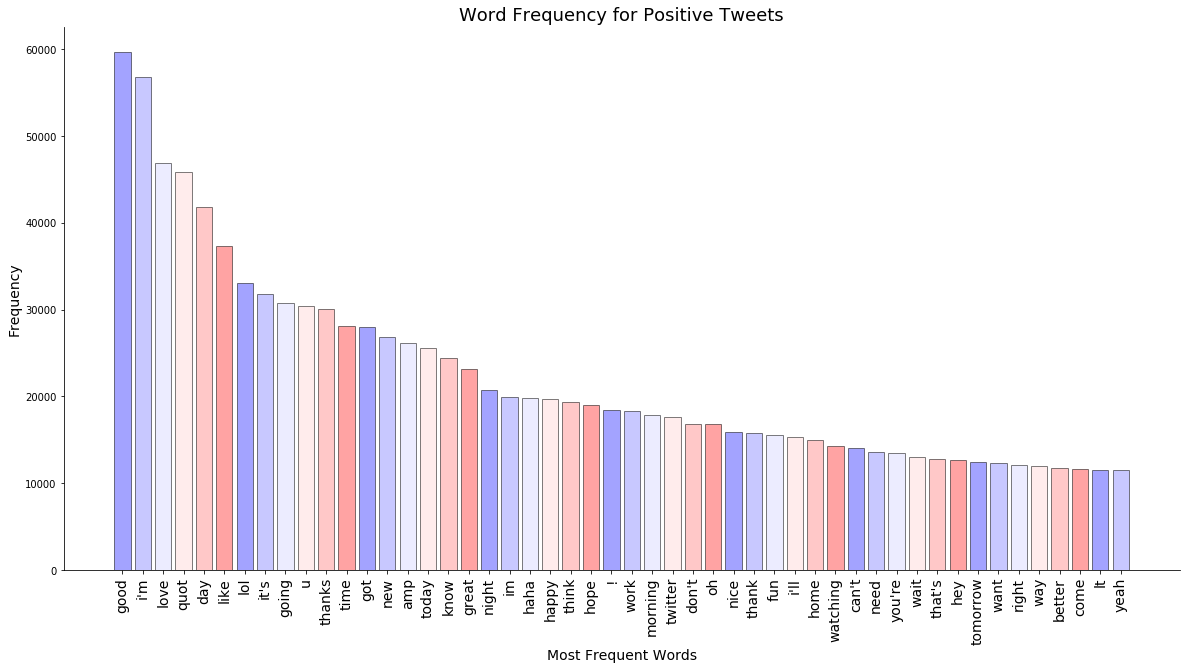

Negative Tweets


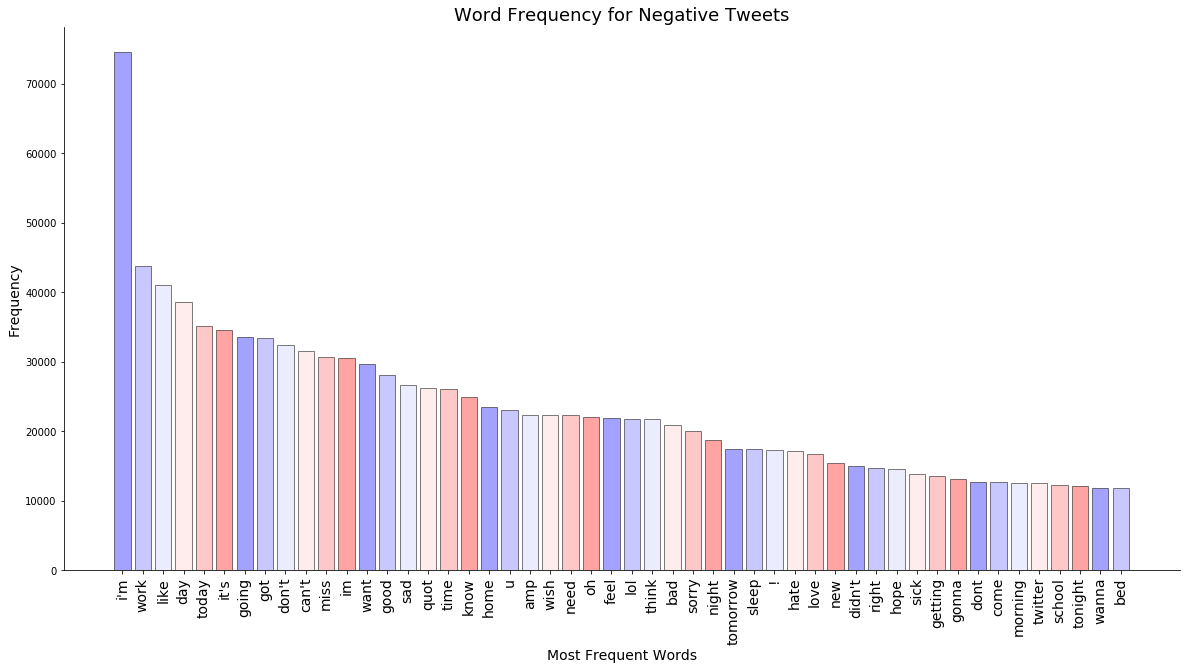

In [16]:
# show word frequency plots for positive and negative tweets
print("Positive Tweets")
show_frequencies(positive_word_dict, "Positive Tweets")
print("Negative Tweets")
show_frequencies(negative_word_dict, "Negative Tweets")

In [17]:
# method to show correlation between word frequencies in positive and negative tweets
def correlation_plot(table):
    table = table[1:]
    sns.set_style("whitegrid")   
    plt.figure(figsize=(12, 10))
    points = plt.scatter(table["positive"], table["negative"], c=table["positive"], s=75, cmap="bwr")
    plt.colorbar(points)
    sns.regplot(x="positive", y="negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word Frequency Correlation - Positive Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

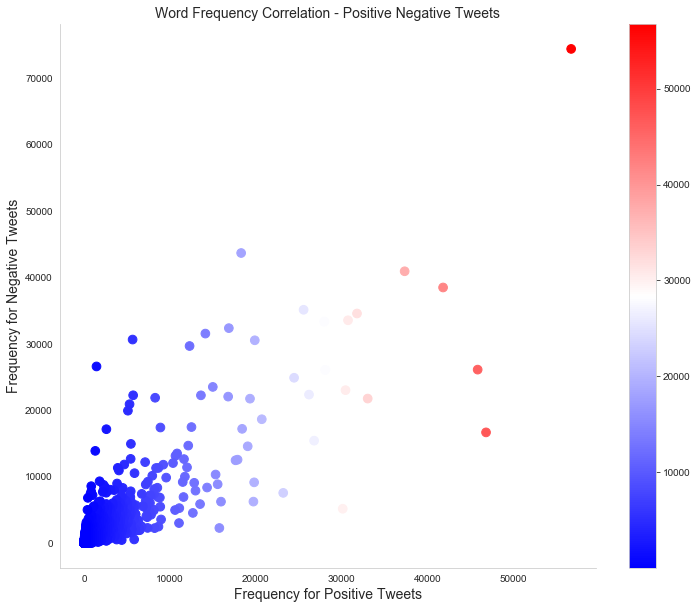

In [18]:
pos = pd.DataFrame(positive_word_dict.items())
pos.columns = ['word', 'positive']
neg = pd.DataFrame(negative_word_dict.items())
neg.columns = ['word', 'negative']
corr = pd.merge(pos, neg, on='word').drop(['word'], axis=1)
correlation_plot(corr)

<h4>Preprocess Data for Sentiment Training</h4>
<ol>
    <li>Create Tokenization and Label Index Dicts and save to files</li>
    <li>Tokenize each row in training dataset</li>
    <li>Truncate/Pad each row to fixed length and Create One Hot Labels Vector per Row for Training BCE for each label</li>
</ol>

In [19]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

# (1) Create Tokenization Index Dict and Label Dict
tokenizer = Tokenizer(lower=False, filters='', num_words=None)     # change num_words to int value to shorten the number of words in tokenized dict
tokenizer.fit_on_texts([j for sub in tweet_words for j in sub]) 
vocabulary = tokenizer.get_config()
   
# from distplot, set max tokens
MAX_TOKENS = 32
# save tokenizer to file
with open('tweet_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load tokenizer from file
# with open('tweet_tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

print("Tokenized word_index dict contains {} entries...".format(len(tokenizer.word_index)))

Tokenized word_index dict contains 365876 entries...


In [20]:
# (2) Tokenize each row in training dataset
tweet_tokens = []
max_index = 0
for words in tweet_words:
    token_lists = tokenizer.texts_to_sequences(words)
    temp = [j for sub in token_lists for j in sub]
    tweet_tokens.append(temp)
    if len(temp) == 0: 
        continue
    max_token_index = max(temp)
    if max_token_index > max_index:
        max_index = max_token_index

print("Number of Entries: Hashed Text = {} -- Raw Tokens = {} -- Labels = {} -- Max Token Index = {} ".format(len(tweet_words), len(tweet_tokens), len(labels), max_index))

Number of Entries: Hashed Text = 1600000 -- Raw Tokens = 1600000 -- Labels = 1600000 -- Max Token Index = 365876 


In [21]:
# (3) Truncate/Pad each row to fixed length and Create One Hot Labels Vector per Row for Training BCE for each label
X = np.zeros((len(tweets), MAX_TOKENS))
y = np.zeros(len(labels))

positive_ctr = 0
negative_ctr = 0
for idx, tokens in enumerate(tweet_tokens):
    # truncate or pad tokens to MAX_TOKENS
    if len(tokens) < MAX_TOKENS:
        X[idx, : len(tokens)] = tokens[:]
    else:
        X[idx, :] = tokens[ : MAX_TOKENS]
    
    # one hot encode labels (use three columns so every label has its own)
    if labels[idx] == 4:
        y[idx] = 1
        positive_ctr += 1
    else:
        negative_ctr += 1

print("Number of positive labels: {} -- Number of negative labels: {}".format(positive_ctr, negative_ctr))

Number of positive labels: 800000 -- Number of negative labels: 800000


In [22]:
from tensorflow.keras import models, initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Embedding, ReLU, LSTM, Bidirectional

# (B) Bidirectional LSTM
# def bilstm(embedding_size, embedding_dim, embedding_matrix, record_dim, num_class=3, dropout=0.1, activation='sigmoid'):  # uncomment for pre-trained embedding
def bilstm(max_word_index, num_feature, num_class=1, embedding_dim=100, dropout=0.1, activation='sigmoid'):  # uncomment for training embedding layer
    model = models.Sequential()
    # Embedding layer. 
    # model.add(Embedding(embedding_size, embedding_dim, weights=[embedding_matrix], input_length=record_dim, trainable=False)) # uncomment for pre-trained embedding
    model.add(Embedding(max_word_index, embedding_dim, input_length=num_feature)) # uncomment for training embedding layer
    # BiLSTM layer
    model.add(Bidirectional(LSTM(MAX_TOKENS, kernel_regularizer=l2(0.01))))
    # Fully Connected Layers
    model.add(Dropout(dropout))
    model.add(Dense(MAX_TOKENS, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout))
    model.add(Dense(num_class, activation=activation, kernel_regularizer=l2(0.01)))
    # try using different optimizers and different optimizer configs
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# Plot Model History
def plot(epochs, history):
    xdata = list(range(1, epochs + 1))
    plt.plot(xdata, history['accuracy'],      label='Train Acc')
    plt.plot(xdata, history['val_accuracy'],  label='Val Acc')
    plt.plot(xdata, history['loss'],     label='Train Loss')
    plt.plot(xdata, history['val_loss'], label='Val Loss')
 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.show()

In [24]:
from sklearn.model_selection import train_test_split
# split training data for test and validation
seed = 42
np.random.seed(seed)
EPOCHS = 5
BATCH_SIZE = 128
# Split training data 80/20 train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

Num GPUs Available:  1
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
1280000/1280000 [==============================] - 3085s 2ms/sample - loss: 0.4971 - accuracy: 0.7915 - val_loss: 0.4542 - val_accuracy: 0.8055
Epoch 2/5
1280000/1280000 [==============================] - 3079s 2ms/sample - loss: 0.4385 - accuracy: 0.8156 - val_loss: 0.4547 - val_accuracy: 0.8045
Epoch 3/5
1280000/1280000 [==============================] - 3076s 2ms/sample - loss: 0.4182 - accuracy: 0.8269 - val_loss: 0.4426 - val_accuracy: 0.8095
Epoch 4/5
1280000/1280000 [==============================] - 3076s 2ms/sample - loss: 0.4022 - accuracy: 0.8361 - val_loss: 0.4415 - val_accuracy: 0.8128
Epoch 5/5
1280000/1280000 [==============================] - 3073s 2ms/sample - loss: 0.3893 - accuracy: 0.8437 - val_loss: 0.4460 - val_accuracy: 0.8113

BiLSTM TRAINING AND VALIDATION COMPLETE... elapsed time: 72640.9375 sec


{'loss': [0.4971235449612141, 0.43847245682477953, 0.41820677993893624, 0.40223

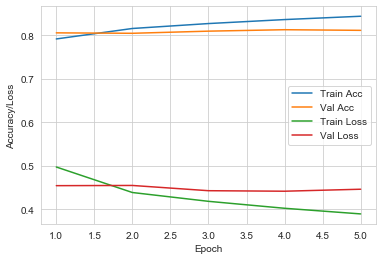

In [25]:
# train BiLSTM model
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print("Num GPUs Available: ", len(physical_devices))
start_time = time.process_time()  
lstm_model = bilstm(max_index + 1, MAX_TOKENS)
history =lstm_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))
print('\nBiLSTM TRAINING AND VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

lstm_model.save('sent_tweet_classifier_bilstmn.h5')
print("\n")
print(history.history)
print("\n")
plot(EPOCHS, history.history)

In [26]:
from sklearn.model_selection import GridSearchCV, KFold

# Test bilstm with K-fold cross validation
start_time = time.process_time()
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
    lstm_model.fit(X[train], y[train], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    scores = lstm_model.evaluate(X[test], y[test], verbose=0)
    print("{0:s} : {1:.2f}".format(lstm_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("{0:.2f} (+/-{1:.2f})".format(np.mean(cvscores), np.std(cvscores)))
print('\nBiLSTM K-FOLD CROSS VALIDATION COMPLETE... elapsed time: {} sec'.format(time.process_time() - start_time))

accuracy : 81.15
accuracy : 83.91
accuracy : 86.29
accuracy : 86.96
accuracy : 87.16
accuracy : 87.91
accuracy : 88.22
accuracy : 88.53
accuracy : 88.74
accuracy : 89.07
86.80 (+/-2.36)

BiLSTM K-FOLD CROSS VALIDATION COMPLETE... elapsed time: 815285.5 sec
